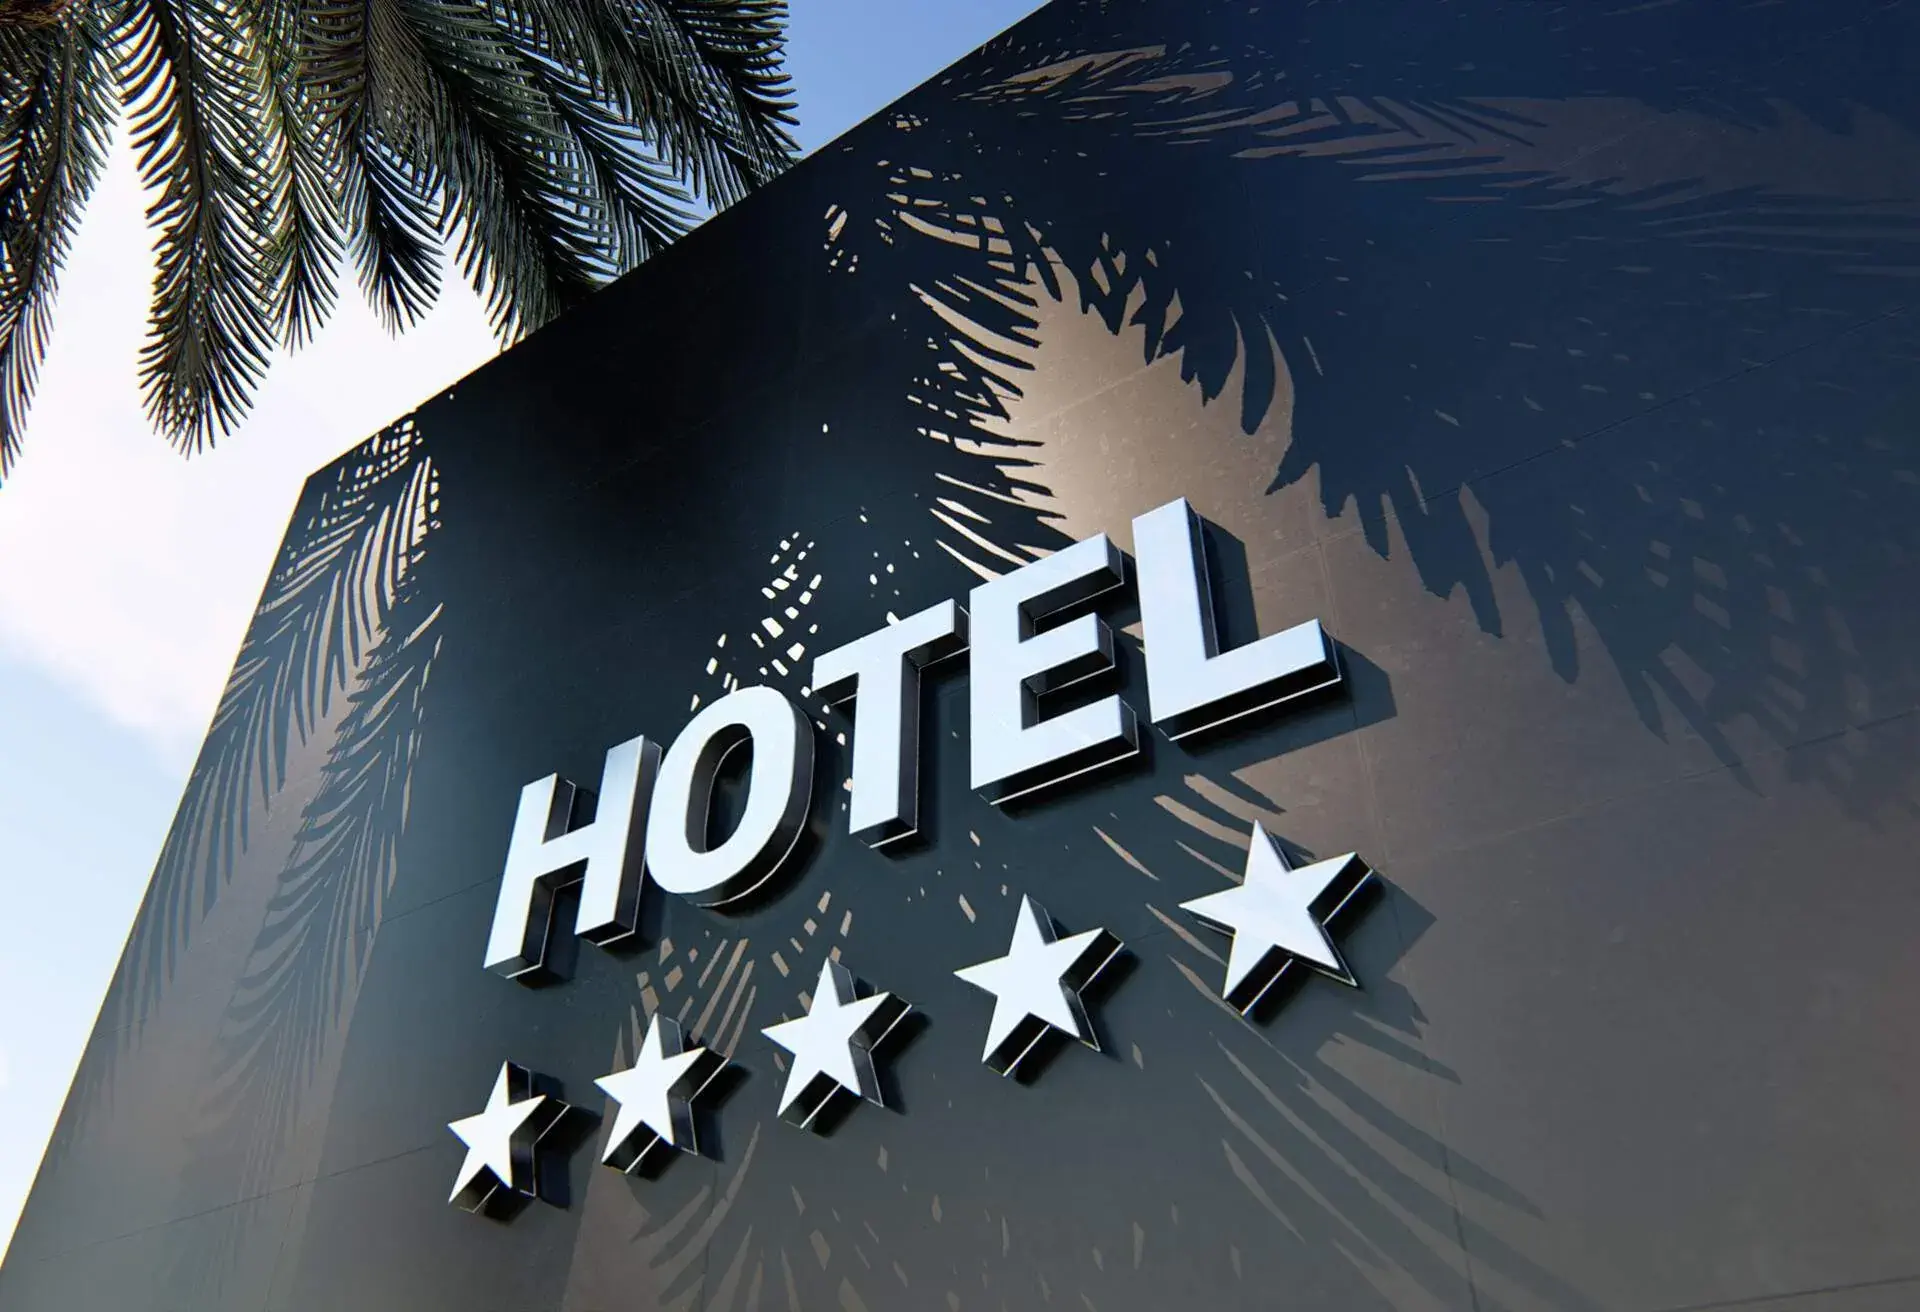

# Hotel Bookings

### 🏨Executive Summary 

Hotels collect detailed booking information — such as arrival dates, length of stay, guest count, and booking status — but this raw data does not clearly indicate which customers or reservations offer the most value to the business.
Without insights derived from factors such as actual revenue contribution, customer value segmentation, or loyalty patterns, hotel managers lack the ability to:
1.	Determine their most profitable customer segments🚩
2.	Assess reservation patterns that result in cancellations or short stays🚩
3.	Create impactful pricing, promotional, and retention strategies🚩

Consequently, the business problem is the absence of actionable intelligence in the raw dataset. The objective of the project is to fill this gap by enhancing the data with analytical features that measure value, loyalty, and booking performance — turning operational records into actionable insights for decision-making.

The Hotel Booking Demand dataset includes comprehensive records of bookings, including arrival dates, stay durations, customer types, and booking statuses. Nonetheless, although it contains abundant operational data, it is deficient in high-level business metrics that reveal customer behaviour and trends in hotel performance.

To extract actionable insights, we systematically cleaned and validated the data — handling missing values, removing duplicates, and correcting outliers — and engineered new features that reflect guest value, loyalty, booking risk, and seasonal trends.

This feature engineering focuses on converting a raw hotel booking dataset into a more informative and analysis-ready format by identifying missing business information and creating valuable features.
Key enrichments include:
1.	Cancellation Risk Scores✅
Quantifies the probability of a booking being cancelled (0–100) using key risk factors such as lead time, seasonality, market segment, and booking characteristics, enabling better overbooking and pricing strategies.
2.	Guest Loyalty Segmentation✅
Classifies guests into high, medium, or low loyalty tiers based on behavioural indicators such as repeat bookings and past cancellations, supporting customer retention and rewards programs.
3.	Revenue and Profitability Indicators✅
Categorises each booking by arrival month to capture temporal demand trends and guide pricing and resource allocation decisions.

These engineered features convert the Hotel Booking Demand dataset from raw operational data into a decision-support resource, offering practical insights that improve hotel performance, profitability, and strategic planning.


In [388]:
import numpy as np
import pandas as pd

In [389]:
### Load dataset ###
def Load_csv(path_in: str = "hotel_bookings.csv") -> pd.DataFrame:
    """
    Load dataset into a pandas DataFrame.
    """
    df = pd.read_csv(path_in)
    print(f"Loaded: {path_in}")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
    return df

In [390]:
### Find and summarize missing value in each columns ###
def Find_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find missing values in each column and summarize.
    """
    na_count = df.isna().sum().sort_values(ascending=False)
    na_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
    missing_summary = pd.DataFrame({"missing_count": na_count, "missing_pct": na_pct})
    print("Missing values by column (pre-cleaning):")
    print(missing_summary[missing_summary["missing_count"] > 0])
    print(f"\nTotal missing cells: {int(df.isna().sum().sum()):,}")
    print(f"Rows with ≥1 missing value: {int(df.isna().any(axis=1).sum()):,}\n")
    return df


In [391]:
### Find and remove duplicate rows ###
def Remove_dup_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find and drop duplicates in the DataFrame.
    """
    dup_count = int(df.duplicated(keep="first").sum())
    print(f"Exact duplicate rows (pre-cleaning): {dup_count:,}")
    before = len(df)
    df = df.drop_duplicates(keep="first").reset_index(drop=True)

    print(f"Removed {before - len(df)} duplicates. New shape: {df.shape}\n")
    return df

In [392]:
### Data cleaning / imputation ###
def Fill_zero_col(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Fill 0 for missing data in columns "agent", "children", "company" 
    """
    # Fill 0 for agent, children, company 
    zero_fill_cols = [ "children", "company", "agent"]
    for col in zero_fill_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
            # keep as integer if possible
            try:
                df[col] = df[col].astype("Int64")
            except Exception:
                pass
    return df

In [393]:
def Fill_mode_col(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Fill mode for missing data in columns "country"
    """
    # Fill mode for country
    if "country" in df.columns:
        mode_country = df["country"].mode(dropna=True)
        mode_country_value = mode_country.iloc[0] if not mode_country.empty else "Unknown"
        df["country"] = df["country"].fillna(mode_country_value).astype(str)
    return df

In [394]:
def Convert_neg_values(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Convert negative values to zero for numeric columns 
    """
    # Convert negative values to zero (numeric columns only)
    num_cols = df.select_dtypes(include=["number"]).columns
    # Count negatives per numeric column
    neg_col_counts = (df[num_cols] < 0).sum()
    cols_with_negs = neg_col_counts[neg_col_counts > 0]
    # Replace negatives with 0 in ALL numeric columns with negatives
    df[num_cols] = df[num_cols].clip(lower=0)

    if not cols_with_negs.empty:
        print("Negative values found and set to 0 in numeric columns:")
        # Summarize columns with negative values
        print(cols_with_negs.rename("negatives_corrected").to_frame())
    else:
        print("No negative numeric values found.\n")
    return df

In [ ]:
### Output cleaned dataset ###
def cleaned_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform data cleaning and pre-processing then output a clean dataframe.
    """

    df2 = Find_missing_values(df)
    df3 = Remove_dup_values(df2)
    df4 = Fill_zero_col(df3)
    df5 = Fill_mode_col(df4)
    clean_df = Convert_neg_values(df5)

    return clean_df
    

Feature 1 , 2 , 3 

Feature 1

In [396]:
def cal_len_of_stay(data):
    total_stay = []
    number = len(data)
    for x in range(number):
        total = data.loc[x, "stays_in_week_nights"] + data.loc[x, "stays_in_weekend_nights"]
        total_stay.append(total)
    return total_stay

In [397]:
"""def outliers_cap(data, percentile=0.95):
    cleaned=[]
    sorted_data = sorted(data)
    number = len(sorted_data)
    index = int(percentile * (number-1))
    data_cap = sorted_data[index]
    
    for x in data:
            if x>data_cap:
                cleaned.append(data_cap)
            else:
                cleaned.append(x)
    return cleaned"""

'def outliers_cap(data, percentile=0.95):\n    cleaned=[]\n    sorted_data = sorted(data)\n    number = len(sorted_data)\n    index = int(percentile * (number-1))\n    data_cap = sorted_data[index]\n\n    for x in data:\n            if x>data_cap:\n                cleaned.append(data_cap)\n            else:\n                cleaned.append(x)\n    return cleaned'

In [398]:
def len_of_stay(data) -> pd.DataFrame:
    total_stay = cal_len_of_stay(data)
    #without_outliers = outliers_cap(total_stay)
    data["len_of_stay"] = total_stay
    return data

Feature 2 

In [399]:
def revenue_booking(data):
    
    revenue=[]
    # data["adr"] = negative_values(data["adr"])
    
    n = len(data)
    
    for x in range(n):
        if (data.loc[x, "is_canceled"]==1):
            revenue.append(0)
        else:
            adr = data.loc[x, "adr"]
            len_stay = data.loc[x, "len_of_stay"]
            revenue.append(adr*len_stay)
    data["revenue_booking"]= revenue
    # test
    print(data["revenue_booking"].describe())
    return data

Feature 3 (late_booking_flag: 1 if lead_time < 7 days)

In [400]:
def late_booking_flag(data):
    flag_late = []
    values = data["lead_time"]
    for x in values:
        if x<7:
            flag_late.append(1)
        else:
            flag_late.append(0)
    data["late_booking_flag"] = flag_late
    # test
    print(data["late_booking_flag"].unique())
    return data

feature 5

In [401]:
def segment_value(df , bins: int = 3):
    df["segment_value"] = pd.cut(
        df["revenue_booking"], bins=bins, labels=["Low", "Medium", "High"], include_lowest=True
    ).astype("category")
    return df

feature 6

In [402]:
def loyalty_check(df: pd.DataFrame) -> pd.Series:
    """
    Checks the loyalty status of a guest based on repetition of bookings and cancellation history.

    Args:
        is_repeated (int): 1 if a repeated guest, 0 otherwise.
        previous_cancellations (int): Number of previous cancellations.

    Returns:
        int: 1 = loyal (meets either condition), 0 = not loyal.
    """

    df['loyal_check'] = ((df['is_repeated_guest'] == 1) | (df['previous_cancellations'] > 0)).astype(int)

    return df

feature 7

In [403]:
def customer_segment(seg):
    all_kids = seg['children'] + seg['babies']
    
    if seg['adults'] > 1 and all_kids > 0:
        return "Family"
    elif seg['adults'] == 2 and all_kids == 0:
        return "Couple"
    elif seg['adults'] == 1 and all_kids == 0:
        return "Solo"
    
    else:
        return "Others"

In [404]:
def apply_segments(df):
    #pandas function to apply thats run the function for each row and apply it to the new column which is customer segmentation.    
    df['customer_segmentation'] = df.apply(customer_segment, axis=1)
    print(df[['adults','children','babies','customer_segmentation']].head())
    return df

--------------MAIN FEATURES------------------------

Cancelation Risk Score

In [405]:
### Create config dictionary ###
def create_config_dict(lead_time_w: float = 0.225,
                off_season_w: float = 0.225,
                single_party_w: float = 0.225,
                market_histcxl_rate_w: float = 0.225,
                customer_randomness_w: float = 0.1,
                off_season_top_k: int = 3) -> dict:
    
    return {
        "weights": {                 
            "lead_time":    lead_time_w,
            "off_season":   off_season_w,
            "single_party": single_party_w,
            "market_hist_cxl_rate":  market_histcxl_rate_w,
            "customer_randomness":  customer_randomness_w,
        },
        "off_season_top_k": off_season_top_k,       # pick the K least frequent months
    }


In [406]:
### Create Min-max normalisation function ###
def _minmax(x: pd.Series) -> pd.Series:
    """
    Min-Max Normalization function for drivers
    """
    x = pd.to_numeric(x)
    xmin, xmax = x.min(), x.max()
    if pd.isna(xmin) or pd.isna(xmax) or xmax == xmin:
        return pd.Series(np.zeros(len(x)), index=x.index) # return to zero if min = max or NaN for min/max
    return (x - xmin) / (xmax - xmin)

In [407]:
### Determine off-season months ###
def det_off_season_months(df: pd.DataFrame, k: int) -> set:
    """
    Pick the K months with the fewest records as off-season months.
    Ties are handled by standard sort order; if fewer than K months exist, use all available.
    """
    months = df['arrival_date_month']

    counts = months.value_counts(dropna=True)  # counts by month
    counts = counts.sort_values(ascending=True) # ensure month order is by ascending frequency, then alphabetically for ties
    chosen = counts.index[:max(0, min(k, len(counts)))]
    print('Off-season months defined by demand: ',list(chosen))
    return set(chosen)

In [408]:
### Create off-season flag ###
def off_season_component(df: pd.DataFrame, off_months: set) -> pd.Series:
    """
    Create off-season flag component (1 if month in the K least frequent months)
    """
    off_months = det_off_season_months(df, off_months)
    off_season_flag = df['arrival_date_month'].isin(off_months).astype(int)
    return off_season_flag

In [409]:
### Create market historical cancel rate ###
def market_hist_cxl_component(df: pd.DataFrame) -> pd.Series:
    """
    Create market historical cancel rate component (mean of is_canceled by market_segment)
    """
    market_rate = df.groupby('market_segment')['is_canceled'].mean().rename('market_cxl_rate')
    if 'Undefined' in market_rate.index: 
        market_rate.loc['Undefined'] = 1.0 # If `market_segment` is 'Undefined', default `market_cxl_rate = 1`
    df = df.merge(market_rate, on='market_segment', how="left")
    return df["market_cxl_rate"]

In [410]:
### Create single party flag ###
def single_party_component(df: pd.DataFrame) -> pd.Series:
    """
    Create single party flag component (1 adult, no children/babies)
    """
    single_party_flag = ((df['adults'].fillna(0) == 1) & (df['children'].fillna(0) == 0) &
                            (df['babies'].fillna(0) == 0)).astype(int)
    return single_party_flag

In [411]:
### Simulate customer unpredictability ###
def customer_randomness_component(df: pd.DataFrame, seed: int = None) -> pd.Series:
    """
    Generate a customer unpredictability score in [0,1] randomly.
    """
    rng = np.random.default_rng(seed)
    return pd.Series(rng.random(len(df)), index=df.index, name="customer_randomness")

In [412]:
### Create factors dictionary ###
def create_factors_dict(df: pd.DataFrame, cfg: dict, rand_seed: int = None) -> dict:
    """
    Create a dictionary of computed factors for calculation of cancellation risk score.
    Output: Both the factors dictionary and the modified DataFrame with new columns.
    """

    df["lead_time_norm"] = _minmax(df["lead_time"]).fillna(1) # If `lead_time` is missing, default `lead_time_norm = 1`
    df["market_hist_cxl_rate"] = market_hist_cxl_component(df) # Create market historical cancel rate
    df["off_season_flag"] = off_season_component(df, cfg.get("off_season_top_k", 3)) # Create off-season flag
    df["single_party_flag"] = single_party_component(df) # Create single party flag
    df["customer_randomness"] = customer_randomness_component(df, seed=rand_seed).clip(0, 1) # Simulate customer unpredictability

    factors_dict = {
        "lead_time":            df["lead_time_norm"],
        "off_season":           df["off_season_flag"],
        "single_party":         df["single_party_flag"],
        "market_hist_cxl_rate": df["market_hist_cxl_rate"],
        "customer_randomness":  df["customer_randomness"],
    }
    return factors_dict, df 

In [413]:
### Main function to compute cancellation risk score ###
def cal_cxl_risk_score(df: pd.DataFrame, cfg: dict, rand_seed: int = None) -> pd.DataFrame:
    """
    Create rule-based cancellation risk score in [0,100] using:
      - lead_time            (minmax normalisation)
      - off_season_flag      (1 if month in the K least frequent months)
      - single_party_flag    (1 adult, no children/babies)
      - market_hist_cxl_rate (mean of is_canceled by market_segment)
      - customer_randomness  (Uniform[0,1])
    """
    
    w = cfg["weights"]
    factors_dict, cxl_risk_score_df = create_factors_dict(df, cfg, rand_seed)
    
    score = pd.Series(0.0, index=cxl_risk_score_df.index) # initialize score column for accumulation

    # Accumulate weighted sum of factors
    for name, value in factors_dict.items():
      weight = float(w.get(name, 0.0))
  
      if weight == 0:
          continue
      
      score = score.add(weight * value, fill_value=0.0)
      
    
    wsum = sum(abs(x) for x in w.values()) # Total absolute weight sum for normalisation
    cxl_risk_score_df["cxl_risk_score"] = (score / wsum) * 100.0 # Normalise final score to [0,100]
    
    return cxl_risk_score_df

Loyality Matrix

In [414]:
def high_loyalty(df):
    if ((df["previous_cancellations"]==0) and (df["loyal_check"]==1)):
        return "Black Member"
    elif ((df["previous_cancellations"]>0) and (df["loyal_check"]==1)):
        return "Titanium Member"
    elif ((df["revenue_booking"]>200) and (df["loyal_check"]==0)):
        return "Diamond Member"
    else:
        return "Ambassador Member"

In [415]:
def medium_loyalty(df):
    if ((df["previous_cancellations"]==0) and (df["loyal_check"]==1)):
        return "Platinum Member"
    elif ((df["previous_cancellations"]>0) and (df["loyal_check"]==1)):
        return "Gold Member"
    elif ((df["revenue_booking"]>100) and (df["loyal_check"]==0)):
        return "Elite Member"
    else:
        return "Premier Member"

In [416]:
def low_loyalty(df):
    if ((df["previous_cancellations"]==0) and (df["loyal_check"]==1)):
        return "Silver Member"
    elif ((df["previous_cancellations"]>0) and (df["loyal_check"]==1)):
        return "Classic Member"
    elif ((df["revenue_booking"]>50) and (df["loyal_check"]==0)):
        return "Plus Member"
    else:
        return "Member"

In [417]:
def loyalty_matrix(df):
    if df["segment_value"]=="High":
        return high_loyalty(df)
    elif df["segment_value"]=="Medium":
        return medium_loyalty(df)
    elif df["segment_value"]=="Low":
        return low_loyalty(df)
    else:
        "Unclassified"

In [418]:
def assign(df):
    df["loyalty_matrix"] = df.apply(loyalty_matrix,axis=1)
    print( df["loyalty_matrix"].unique())
    return df

Seasonality significantly affects hotel profitability

In [419]:
# Create 'total_nights' = stays_in_week_nights + stays_in_weekend_nights
def compute_total_nights(df):
    df["total_nights"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
    return df

In [420]:
# Infer a coarse 'season' from 'arrival_date_month':
# Summer: June, July, August
# Shoulder: May, September
# Off-peak: others
def infer_season(df):
    month = df.get("arrival_date_month")
    m = pd.Series(month, index=df.index).astype(str).str.title() 
    summer = {"June", "July", "August"}
    shoulder = {"May", "September"}
    df["season"] = np.where(m.isin(summer), "Summer",
                      np.where(m.isin(shoulder), "Shoulder", "Off-peak"))   
    return df

In [421]:
# Derive:
# child_count: numeric children count
# breakfast_pax: number of people charged breakfast if meal plan includes breakfast(meal in {"BB","HB","FB"} → has breakfast)
def derive_breakfast_and_children(df):
    df["child_count"] = pd.Series(df.get("children", 0)).fillna(0).astype(float)
    adults = pd.Series(df.get("adults", 0)).fillna(0).astype(float)
    children = df["child_count"]
    meal = df.get("meal", "")
    has_breakfast = pd.Series(False, index=df.index)
    if isinstance(meal, pd.Series):
        has_breakfast = meal.isin(["BB", "HB", "FB"])
    df["breakfast_pax"] = np.where(has_breakfast, adults + children, 0.0)
    return df

In [422]:
# Compute 'adjusted_revenue' = adr * total_nights * (1 - is_canceled).
def compute_adjusted_revenue(df):
    valid = (df["adr"] >= 0) & (df["total_nights"] >= 0)
    df["adjusted_revenue"] = df["adr"] * df["total_nights"] * (1 - df["is_canceled"])
    df.loc[~valid, "adjusted_revenue"] = np.nan
    return df

In [423]:
# Compute cost per night and total cost.
def add_costs(df):
    """
    Compute per-night and total costs using simple embedded rules:
        - Base variable cost per night = 60
        - Cleaning cost per stay (fixed) = 30
        - Child cost per child per night = 20
        - Breakfast cost per person per night = 6
        - Season uplifts on cost: Summer +20%, Shoulder +10%, Off-peak +0%
        Output: cost_per_night_adj, total_cost
    """
    
    # Embedded constants
    base_cost_per_night = 60.0
    cleaning_cost_per_stay = 30.0
    child_cost_per_night = 20.0
    breakfast_unit_cost = 6.0
    charge_fixed_if_cancelled = False

    season_cost_uplift = {"Summer": 0.20, "Shoulder": 0.10, "Off-peak": 0.00}

    season_up = pd.Series(df["season"]).map(season_cost_uplift).fillna(0.0)

    df["cost_per_night_adj"] = (
        base_cost_per_night * (1 + season_up) 
        + pd.Series(df.get("child_count", 0)).fillna(0) * child_cost_per_night
        + pd.Series(df.get("breakfast_pax", 0)).fillna(0) * breakfast_unit_cost
    )

    if charge_fixed_if_cancelled:
        fixed = cleaning_cost_per_stay
    else:
        fixed = np.where(df["is_canceled"] == 1, 0.0, cleaning_cost_per_stay)

    df["total_cost"] = pd.Series(df["total_nights"]).fillna(0) * df["cost_per_night_adj"] + fixed
    return df

In [424]:
# Compute profit and Booking Profitability Score
def compute_profit_and_score(df):
    '''
    profit = adjusted_revenue - total_cost
    Booking_Profitability_Score: scale profit into [0,100] by clipping to 5th–95th pct
    score = 100 * (clip(profit) - p5) / (p95 - p5)
    If all profits equal (p5≈p95), set score=50 for non-NaN profits
    '''

    df = df.copy()
    df["profit"] = df["adjusted_revenue"] - df["total_cost"]

    prof = df["profit"].dropna()
    if prof.empty:
        df["profit_clip"] = np.nan
        df["Booking_Profitability_Score"] = np.nan
        return df

    p5, p95 = np.nanpercentile(prof, [5, 95])
    if np.isclose(p5, p95):
        df["profit_clip"] = df["profit"]
        df["Booking_Profitability_Score"] = 50.0
        return df

    df["profit_clip"] = df["profit"].clip(lower=p5, upper=p95)
    df["Booking_Profitability_Score"] = 100 * (df["profit_clip"] - p5) / (p95 - p5)
    return df


In [425]:
# Main function to compute booking profitability
def booking_profitability(df):
    df1 = compute_total_nights(df)
    df2 = infer_season(df1)
    df3 = derive_breakfast_and_children(df2)
    df4 = compute_adjusted_revenue(df3)
    df5 = add_costs(df4)
    booking_profitability_df = compute_profit_and_score(df5)
    return booking_profitability_df

In [426]:
### Save enriched dataset ###
def save_csv(df: pd.DataFrame, path_out: str = "hotel_bookings_final_enriched.csv") -> pd.DataFrame:
    '''
    Save and output cleaned dataset into a csv file
    '''
    df.to_csv(path_out, index=False)
    print(f"\nSaved cleaned dataset to: {path_out}")

    return df

In [427]:
def main():
    df = Load_csv(path_in = "hotel_bookings.csv")
    clean_df = cleaned_dataset(df)
    cfg = create_config_dict(lead_time_w = 0.225,
                off_season_w = 0.225,
                single_party_w = 0.225,
                market_histcxl_rate_w = 0.225,
                customer_randomness_w = 0.1,
                off_season_top_k = 3)

    df2 = len_of_stay(clean_df)
    df3 = revenue_booking(df2)
    df4 = late_booking_flag(df3)
    df5 = segment_value(df4)
    df6 = loyalty_check(df5)
    df7 = apply_segments(df6)
                    
    add_cxl_risk_score_df = cal_cxl_risk_score(df7, cfg, rand_seed=42)  # seed for reproducibility if needed
    add_loyalty_matrix_df = assign(add_cxl_risk_score_df)
    add_booking_profitability_df = booking_profitability(add_loyalty_matrix_df)
    final_enriched_df = add_booking_profitability_df.copy()
    save_csv(final_enriched_df, path_out="hotel_bookings_final_enriched.csv")
    # print(final_df.head())

    return final_enriched_df


In [428]:
final_enriched_df = main()

Loaded: hotel_bookings.csv
Shape: 119,390 rows × 32 columns

Missing values by column (pre-cleaning):
          missing_count  missing_pct
agent             16340        13.69
children              4         0.00
company          112593        94.31
country             488         0.41

Total missing cells: 129,425
Rows with ≥1 missing value: 119,173

Exact duplicate rows (pre-cleaning): 31,994
Removed 31994 duplicates. New shape: (87396, 32)

Negative values found and set to 0 in numeric columns:
     negatives_corrected
adr                    1
count    87396.000000
mean       262.906313
std        332.318634
min          0.000000
25%          0.000000
50%        168.000000
75%        378.000000
max       7590.000000
Name: revenue_booking, dtype: float64
[0 1]
   adults  children  babies customer_segmentation
0       2         0       0                Couple
1       2         0       0                Couple
2       1         0       0                  Solo
3       1         0       0

In [429]:
print(final_enriched_df["cxl_risk_score"].describe())

count    87396.000000
mean        21.586197
std         12.516077
min          2.836039
25%         12.610483
50%         17.047881
75%         31.315247
max         75.670172
Name: cxl_risk_score, dtype: float64
